In [6]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

class InputCasNet(nn.Module):
    def __init__(self):
        super(InputCasNet, self).__init__()
        self.first_upper_layer1=nn.Sequential(
            nn.Conv2d(4,64,7),
            nn.ReLU(),
            nn.MaxPool2d((4,4),stride = 1)
        )
        self.first_upper_layer2=nn.Sequential(
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride = 1)
        )
        self.first_under_layer1=nn.Sequential(
            nn.Conv2d(4,160,13),
            nn.ReLU()
        )
        
        self.first_final_layer=nn.Conv2d(224,5,21)
        
        self.second_upper_layer1=nn.Sequential(
            nn.Conv2d(9,64,7),
            nn.ReLU(),
            nn.MaxPool2d((4,4),stride = 1)
        )
        self.second_upper_layer2=nn.Sequential(
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride = 1)
        )
        self.second_under_layer1=self.under_layer1 = nn.Sequential(
            nn.Conv2d(9,160,13),
            nn.ReLU()
        )
        self.second_final_layer = nn.Conv2d(224,5,21)
    
    def forward(self, x1):
        upper_x=self.first_upper_layer2(self.first_upper_layer1(x1))
        under_x=self.first_under_layer1(x1)
        x=torch.cat((upper_x, under_x), 1)
        x=self.first_final_layer(x)
        x2=x1[:, :, 16:48+1, 16:48+1]*1.0
        x2=torch.cat((x, x2), 1)
        upper_x2=self.second_upper_layer2(self.second_upper_layer1(x2))
        under_x2=self.second_under_layer1(x2)
        x3=torch.cat((upper_x2, under_x2), 1)
        x3=self.second_final_layer(x3)
        return x3

    
import h5py
#challenge_f = h5py.File('Challenge.h5', 'r') #load challenge data
train_f = h5py.File('train.h5', 'r')
SAMPLE = [ "LG/0001", "LG/0002", "LG/0004", "LG/0006", "LG/0008", "LG/0011",
          "LG/0012", "LG/0013", "LG/0014", "LG/0015", "HG/0001", "HG/0002",
          "HG/0003", "HG/0004", "HG/0005", "HG/0006", "HG/0007", "HG/0008",
          "HG/0009", "HG/0010", "HG/0011", "HG/0012", "HG/0013", "HG/0014",
          "HG/0015", "HG/0022", "HG/0024", "HG/0025", "HG/0026", "HG/0027",]
'''
train_f = h5py.File('Challenge.h5', 'r')
SAMPLE = [ "HG/0301", "HG/0302",
          "HG/0303", "HG/0304", "HG/0305", "HG/0306", "HG/0307", "HG/0308",
          "HG/0309", "HG/0310", ]
'''
#for i in enumerate(SAMPLE):
#    index, case = i
#    case1 = case[:2]
#    case2 = case[3:]
#    print(challenge_f[case1][case2].shape)
    
def create_test_batch(img = 0, x = 16, z= 0):
    case = SAMPLE[img]
    case1 = case[:2]
    case2 = case[3:]
    batch = []
    _, X, Y, Z = train_f[case1][case2].shape
    img1 = train_f[case1][case2][:,:,:,z]
    img1 = np.pad(img1, pad_width = ((0,0), (16,16), (16,16)), mode = 'constant')
    for y in range(16, Y + 16):
        batch.append(img1[:, x-16:x+17, y-16:y+17])
    batch = torch.from_numpy(np.array(batch))
    return batch

def create_test_batch_cas(img = 0, x = 32, z= 0, f = train_f['HG']['0001']):
    batch = []
    _, X, Y, Z = f.shape
    img1 = f[:,:,:,z]
    img1 = np.pad(img1, pad_width = ((0,0), (32,32), (32,32)), mode = 'constant')
    for y in range(32, Y + 32):
        batch.append(img1[:, x-32:x+33, y-32:y+33])
    batch = torch.from_numpy(np.array(batch))
    return batch

# In[ ]:

In [2]:
import time
import numpy as np
from torch.autograd import Variable
#net = TwoPathConv()
#net = LocalPathConv()
net = InputCasNet()
#net.load_state_dict(torch.load('two_path_cnn/p2_TPWconv_net1.txt'))
#net.load_state_dict(torch.load('local_path_cnn/phase2_param4.txt'))
net.load_state_dict(torch.load('phase2_input_cas_net.txt'))
net.cuda(1)

InputCasNet (
  (first_upper_layer1): Sequential (
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU ()
    (2): MaxPool2d (size=(4, 4), stride=(1, 1), dilation=(1, 1))
  )
  (first_upper_layer2): Sequential (
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  )
  (first_under_layer1): Sequential (
    (0): Conv2d(4, 160, kernel_size=(13, 13), stride=(1, 1))
    (1): ReLU ()
  )
  (first_final_layer): Conv2d(224, 5, kernel_size=(21, 21), stride=(1, 1))
  (second_upper_layer1): Sequential (
    (0): Conv2d(9, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU ()
    (2): MaxPool2d (size=(4, 4), stride=(1, 1), dilation=(1, 1))
  )
  (second_upper_layer2): Sequential (
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  )
  (second_under_layer1): Sequential (
    (0): Conv2d(9, 160, ke

In [8]:
torch.save(net.state_dict(), "/home/yiqin/p2_input_cas_net.txt")

In [9]:
prev_time = time.clock()
#print(matrix_pred)
s = 0
#matrix_pred = {}
pred = {}
matrix_pred ={}

for img in range(10, 11):
    case = SAMPLE[img]
    case1 = case[:2]
    case2 = case[3:]
    #_, X, Y, Z = challenge_f[case1][case2].shape
    _, X, Y, Z = train_f[case1][case2].shape
    print(X, Y, Z)
    matrix_pred[img] = []
    #for x in range(16, X + 16):
    f = train_f[case1][case2]
    for x in range(32, X + 32):
        pred[(img,x)] = []
        for z in range(Z):
            s += 1
            #X_batch = create_test_batch(img = img, x = x, z = z)
            X_batch = create_test_batch_cas(img = img, x = x, z = z, f = f)
            X_batch = Variable(X_batch.cuda(1))
            y_pred = net.forward(X_batch)
            y_pred = y_pred.data.cpu().numpy()
            pred[(img,x)].append(y_pred.argmax(axis = 1)) 
        print ('Ongoing ...' ,(img, x, z))
        print ('time used %.3f' % (time.clock()-prev_time))
        matrix_pred[img].append(pred[(img,x)])
        print(np.array(matrix_pred[img]).shape)
array_img = np.array(matrix_pred[10]).transpose(1,2,0)
print(array_img.shape)

160 216 176
Ongoing ... (10, 32, 175)
time used 35.554
(1, 176, 216, 1, 1)
Ongoing ... (10, 33, 175)
time used 71.811
(2, 176, 216, 1, 1)
Ongoing ... (10, 34, 175)
time used 108.023
(3, 176, 216, 1, 1)
Ongoing ... (10, 35, 175)
time used 143.991
(4, 176, 216, 1, 1)
Ongoing ... (10, 36, 175)
time used 180.073
(5, 176, 216, 1, 1)
Ongoing ... (10, 37, 175)
time used 215.910
(6, 176, 216, 1, 1)
Ongoing ... (10, 38, 175)
time used 251.749
(7, 176, 216, 1, 1)
Ongoing ... (10, 39, 175)
time used 287.638
(8, 176, 216, 1, 1)
Ongoing ... (10, 40, 175)
time used 323.520
(9, 176, 216, 1, 1)
Ongoing ... (10, 41, 175)
time used 359.381
(10, 176, 216, 1, 1)
Ongoing ... (10, 42, 175)
time used 394.752
(11, 176, 216, 1, 1)
Ongoing ... (10, 43, 175)
time used 430.315
(12, 176, 216, 1, 1)
Ongoing ... (10, 44, 175)
time used 465.604
(13, 176, 216, 1, 1)
Ongoing ... (10, 45, 175)
time used 500.596
(14, 176, 216, 1, 1)
Ongoing ... (10, 46, 175)
time used 536.268
(15, 176, 216, 1, 1)
Ongoing ... (10, 47, 175

Ongoing ... (10, 156, 175)
time used 4507.105
(125, 176, 216, 1, 1)
Ongoing ... (10, 157, 175)
time used 4542.829
(126, 176, 216, 1, 1)
Ongoing ... (10, 158, 175)
time used 4578.370
(127, 176, 216, 1, 1)
Ongoing ... (10, 159, 175)
time used 4614.073
(128, 176, 216, 1, 1)
Ongoing ... (10, 160, 175)
time used 4649.715
(129, 176, 216, 1, 1)
Ongoing ... (10, 161, 175)
time used 4685.421
(130, 176, 216, 1, 1)
Ongoing ... (10, 162, 175)
time used 4721.059
(131, 176, 216, 1, 1)
Ongoing ... (10, 163, 175)
time used 4756.633
(132, 176, 216, 1, 1)
Ongoing ... (10, 164, 175)
time used 4792.047
(133, 176, 216, 1, 1)
Ongoing ... (10, 165, 175)
time used 4827.785
(134, 176, 216, 1, 1)
Ongoing ... (10, 166, 175)
time used 4863.763
(135, 176, 216, 1, 1)
Ongoing ... (10, 167, 175)
time used 4899.711
(136, 176, 216, 1, 1)
Ongoing ... (10, 168, 175)
time used 4935.826
(137, 176, 216, 1, 1)
Ongoing ... (10, 169, 175)
time used 4971.726
(138, 176, 216, 1, 1)
Ongoing ... (10, 170, 175)
time used 5007.606
(1

ValueError: axes don't match array

In [14]:
array_img = np.array(matrix_pred[10])
array_img = array_img[:,:,:,0,0].transpose(1,2,0)

In [15]:
print(array_img.shape)
import pickle as pkl
output1 = open('HG0001-cas.pkl', 'wb')
pkl.dump(array_img, output1, protocol = 2)

(176, 216, 160)


(176, 216, 160)


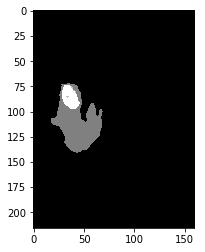

In [16]:
print(array_img.shape)
#plt.imshow(matrix_pred[img][:,100,:], cmap='gray')
plt.imshow(array_img[100,:,:], cmap='gray')
plt.show()

In [ ]:
val_patch_size = 256
iteration = len(val_list) // val_patch_size
prev_time = time.clock()
correct = 0
for j in range(iteration):
    val_x, val_y = create_val_patch(val_patch_size, key = j)
    val_x, val_y = Variable(val_x.cuda(3)), val_y.cuda(3)
    #train
    #check accuracy
    val_pred = net.forward(val_x)
    val_pred = val_pred.view(-1, 5)
    _, predicted = torch.max(val_pred.data, 1)
    correct += (predicted == val_y).sum()
    total_test_size = val_patch_size * (j+1)
    if j % 10 == 0:
        print('iteration %d /%d:'%(j, iteration))
        print(float(j)/iteration,  'finished')
        print('Validation accuracy:', float(correct) / total_test_size)
        print('time used:%.3f'% (time.clock() - prev_time))

In [10]:
#cas-net test

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import h5py
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
import time
import torch.nn.init as ini
import multiprocessing
from multiprocessing import Queue
import random
from random import shuffle
import pickle

class InputCasNet(nn.Module):
    def __init__(self):
        super(InputCasNet, self).__init__()
        self.first_upper_layer1=nn.Sequential(
            nn.Conv2d(4,64,7),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((4,4),stride = 1)
        )
        self.first_upper_layer2=nn.Sequential(
            nn.Conv2d(64,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride = 1)
        )
        self.first_under_layer1=nn.Sequential(
            nn.Conv2d(4,160,13),
            nn.BatchNorm2d(160),
            nn.ReLU()
        )
        
        self.first_final_layer=nn.Conv2d(224,5,21)
        
        self.second_upper_layer1=nn.Sequential(
            nn.Conv2d(9,64,7),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((4,4),stride = 1)
        )
        self.second_upper_layer2=nn.Sequential(
            nn.Conv2d(64,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride = 1)
        )
        self.second_under_layer1=self.under_layer1 = nn.Sequential(
            nn.Conv2d(9,160,13),
            nn.BatchNorm2d(160),
            nn.ReLU()
        )
        self.second_final_layer = nn.Conv2d(224,5,21)
    
    def forward(self, x1):
        upper_x=self.first_upper_layer2(self.first_upper_layer1(x1))
        under_x=self.first_under_layer1(x1)
        x=torch.cat((upper_x, under_x), 1)
        x=self.first_final_layer(x)
        x2=x1[:, :, 16:48+1, 16:48+1]*1.0
        x2=torch.cat((x, x2), 1)
        upper_x2=self.second_upper_layer2(self.second_upper_layer1(x2))
        under_x2=self.second_under_layer1(x2)
        x3=torch.cat((upper_x2, under_x2), 1)
        x3=self.second_final_layer(x3)
        return x3

cas_net=InputCasNet()
cas_net.load_state_dict(torch.load('phase1_input_cas_net.txt'))
cas_net.cuda(0)

InputCasNet (
  (first_upper_layer1): Sequential (
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(4, 4), stride=(1, 1), dilation=(1, 1))
  )
  (first_upper_layer2): Sequential (
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  )
  (first_under_layer1): Sequential (
    (0): Conv2d(4, 160, kernel_size=(13, 13), stride=(1, 1))
    (1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
  )
  (first_final_layer): Conv2d(224, 5, kernel_size=(21, 21), stride=(1, 1))
  (second_upper_layer1): Sequential (
    (0): Conv2d(9, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(4, 4), stride=(1, 1), dilation=(1, 1)

In [17]:
f_c = h5py.File('Challenge.h5', 'r')
SAMPLE = [ "HG/0301", "HG/0302",
          "HG/0303", "HG/0304", "HG/0305", "HG/0306", "HG/0307", "HG/0308",
          "HG/0309", "HG/0310", ]


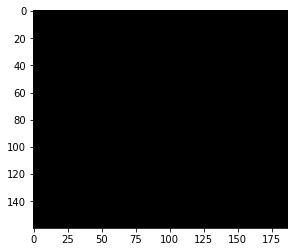

In [19]:
plt.imshow(f_c['HG']['0302'][3,:,:,100], cmap='gray')
plt.show()